In [1]:
from __future__ import annotations
import pandas as pd 
from scipy.stats.contingency import odds_ratio
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import itertools
import numpy as np

warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.options.display.float_format = "{:,.2f}".format
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

In [2]:
# load to dataframe
INFILE = '/home/grace/work/SEER/data/SEERPLUS_2010_2020.clean.tsv'
master = pd.read_csv(INFILE, header=0, sep='\t', na_values='.')

In [3]:
# basic formatting
from util_funcs import do_basic_formatting
from util_funcs import format_cancer_subtypes
from util_funcs import std_tstage, std_nstage, std_gstage, std_grade

HISTTYPES_PATH = '/home/grace/work/SEER/data/histology/histcodes.tsv'
print('\nBasic formatting')
df = do_basic_formatting(master, HISTTYPES_PATH)
df = format_cancer_subtypes(df)

print('TNG, Grade standardisation')
df['TSTAGE_STD'] = df['t_stage_ajcc'].apply(std_tstage)
df['NSTAGE_STD'] = df['n_stage_ajcc'].apply(std_nstage)
df['GSTAGE_STD'] = df['g_stage_ajcc'].apply(std_gstage)
df['GRADE_STD'] = df['grade'].apply(std_grade)

print('\nFiltering')
print('Selecting records with MALIGNANT behavior')
irecords = df.shape[0]
df = df[df['behavior']=='MALIGNANT']
print(f'- removed {irecords - df.shape[0]} records')

print('Handling patients with multiple records of same cancer_type')
irecords = df.shape[0]
# df = df[~df.duplicated(subset=['patient_id', 'cancer_type', 'hist_cateogry'])]
df = df[~df.duplicated(subset=['patient_id', 'cancer_type'])]
print(f'- removed {irecords - df.shape[0]} records')

print(f'\nFinal records: {df.shape[0]}, patients: {len(df.patient_id.unique())}')
df.head()


Basic formatting
Missing 0 codes.
TNG, Grade standardisation

Filtering
Selecting records with MALIGNANT behavior
- removed 632160 records
Handling patients with multiple records of same cancer_type
- removed 82353 records

Final records: 4518561, patients: 4238366


,patient_id,patient_death_year,diagnosis_year,followup_year,diagnosis_agebin,cancer_type,cancer_group,primary_type,primary_group,t_stage_ajcc,n_stage_ajcc,g_stage_ajcc,t_stage_src,n_stage_src,g_stage_src,grade,grade_src,regional_nodes,regional_nodes_examined,regional_nodes_positive,behavior,num_malignant_tumors,num_benign_tumors,psa,breast_subtype,hist_type,hist_cateogry,brain_met,bone_met,lung_met,liver_met,distant_ln,hist_type_descr,TSTAGE_STD,NSTAGE_STD,GSTAGE_STD,GRADE_STD
1,137,"2,017.00",2012,2017,85-89 years,Myeloma,Leukemia,Myeloma,Leukemia,NaN,NaN,NaN,NaN,NaN,NaN,T_CELL,NaN,NaN,NaN,NaN,MALIGNANT,2,0,NaN,NaN,9732,plasma cell tumors,NO,NO,NO,NO,NO,Plasma cell myeloma,NaN,NaN,NaN,T_CELL
4,139,"2,011.00",2010,2011,70-74 years,Breast,Breast,Breast,Breast,T3,N0,IIB,NaN,NaN,NaN,G3,NaN,NEG,3.00,0.00,MALIGNANT,3,0,NaN,HR-/HER2-,8500,ductal and lobular neoplasms,NO,NO,NO,NO,NO,Infiltrating duct carcinoma [+ others],T3,N0,II,G3
5,142,NaN,2018,2020,70-74 years,Breast,Breast,Breast,Breast,T2,N0,IIA,NaN,NaN,NaN,G3,P,NEG,3.00,0.00,MALIGNANT,2,0,NaN,HR-/HER2-,8500,ductal and lobular neoplasms,NO,NO,NO,NO,NO,Infiltrating duct carcinoma [+ others],T2,N0,II,G3
6,194,NaN,2016,2020,55-59 years,Ovary,Ovary,Ovary,Ovary,T1c,N0,IC,P,P,NaN,G2,NaN,NEG,10.00,0.00,MALIGNANT,2,0,NaN,NaN,8441,"cystic, mucinous and serous neoplasms",NO,NO,NO,NO,NO,Serous carcinoma [+ others],T1,N0,I,G2
7,220,NaN,2011,2020,70-74 years,Prostate,Prostate,Prostate,Prostate,T1c,N0,II,NaN,NaN,NaN,G2,NaN,NaN,0.00,NaN,MALIGNANT,2,0,6.60,NaN,8140,adenomas and adenocarcinomas,NO,NO,NO,NO,NO,Adenoma [+ others],T1,N0,II,G2


In [4]:
df['regional_nodes_prop'] = np.nan
df['regnodes_exam_bin'] = np.nan
df['regnodes_pos_bin'] = np.nan
df['regnodes_prop_bin'] = np.nan

# proportion
mask = (df['regional_nodes_examined'] > 0) & (df['regional_nodes_positive'] >= 0)
df.loc[mask, 'regional_nodes_prop'] = (df.loc[mask]['regional_nodes_positive'] / df.loc[mask]['regional_nodes_examined'])

# num examined bin
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
mask = df['regional_nodes_examined'] >= 0
df.loc[mask, 'regnodes_exam_bin'] = pd.cut(df['regional_nodes_examined'], bins, include_lowest=True).astype(str)
df.loc[df['regnodes_exam_bin']=='(-0.001, 10.0]', 'regnodes_exam_bin'] = '(0, 10]'

# num examined bin
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
mask = df['regional_nodes_positive'] >= 0
df.loc[mask, 'regnodes_pos_bin'] = pd.cut(df['regional_nodes_positive'], bins, include_lowest=True).astype(str)
df.loc[df['regnodes_pos_bin']=='(-0.001, 10.0]', 'regnodes_pos_bin'] = '(0, 10]'

# proportion bin
bins = [0.00, 0.25, 0.50, 0.75, 1.00]
mask = df['regional_nodes_prop'] >= 0
df.loc[mask, 'regnodes_prop_bin'] = pd.cut(df['regional_nodes_prop'], bins, include_lowest=True).astype(str)
df.loc[df['regnodes_prop_bin']=='(-0.001, 0.25]', 'regnodes_prop_bin'] = '(0.00, 0.25]'

In [5]:
print(df['regnodes_exam_bin'].value_counts())
print()
print(df['regnodes_pos_bin'].value_counts())
print()
print(df['regnodes_prop_bin'].value_counts())

df[['patient_id', 'regional_nodes_examined', 'regnodes_exam_bin', 'regional_nodes_positive', 'regnodes_pos_bin', 'regional_nodes_prop', 'regnodes_prop_bin', 'regional_nodes']].head(20)

regnodes_exam_bin
(0, 10]         2998248
(10.0, 20.0]     349574
(20.0, 30.0]     142548
(30.0, 40.0]      48840
(40.0, 50.0]      19051
(50.0, 60.0]       8660
(60.0, 70.0]       4223
(80.0, 90.0]       3314
(70.0, 80.0]       2301
Name: count, dtype: int64

regnodes_pos_bin
(0, 10]         1452636
(10.0, 20.0]      26856
(20.0, 30.0]       5355
(30.0, 40.0]       1333
(40.0, 50.0]        387
(50.0, 60.0]        148
(60.0, 70.0]         57
(80.0, 90.0]         37
(70.0, 80.0]         32
Name: count, dtype: int64

regnodes_prop_bin
(0.00, 0.25]    1240130
(0.25, 0.5]      102842
(0.75, 1.0]       75268
(0.5, 0.75]       36296
Name: count, dtype: int64


,patient_id,regional_nodes_examined,regnodes_exam_bin,regional_nodes_positive,regnodes_pos_bin,regional_nodes_prop,regnodes_prop_bin,regional_nodes
1,137,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,139,3.00,"(0, 10]",0.00,"(0, 10]",0.00,"(0.00, 0.25]",NEG
5,142,3.00,"(0, 10]",0.00,"(0, 10]",0.00,"(0.00, 0.25]",NEG
6,194,10.00,"(0, 10]",0.00,"(0, 10]",0.00,"(0.00, 0.25]",NEG
7,220,0.00,"(0, 10]",NaN,NaN,NaN,NaN,NaN
8,265,0.00,"(0, 10]",NaN,NaN,NaN,NaN,NaN
9,285,0.00,"(0, 10]",NaN,NaN,NaN,NaN,NaN
10,309,7.00,"(0, 10]",1.00,"(0, 10]",0.14,"(0.00, 0.25]",POS_NODES
11,314,0.00,"(0, 10]",NaN,NaN,NaN,NaN,NaN
12,344,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Relative risk / odds ratio of Met:

- No loco   -> Loco (only)
- No loco   -> Dist (only)
- No loco   -> Loco (any) 
- No loco   -> Dist (any)
- No loco   -> Loco & Dist
- Loco -> Dist (only) 
- Loco -> Dist (any)
- Loco -> Loco & Dist

```
Brain   ------|-x-----
Bone    ------|-----x-
Lung    ----x-|-------
Liver   ----x-|-------
```


In [6]:
from typing import Tuple 
from util_funcs import calculate_met_stats

temp = df.dropna(subset=['regnodes_prop_bin'])
# n_yes = df[df['brain_met']=='YES'].shape[0]
# n_no = df[df['brain_met']=='NO'].shape[0]
# stats = calculate_met_stats(
#     feature='regnodes_prop_bin',
#     response='brain_met',
#     df=temp,
#     baseline_fval='(0.00, 0.25]'
# )

maintable = pd.DataFrame()
for response in ['brain_met', 'bone_met', 'lung_met', 'liver_met', 'distant_ln']:
    stats = calculate_met_stats(
        feature='regnodes_prop_bin',
        response=response,
        df=temp,
        baseline_fval='(0.00, 0.25]'
    )
    stats = stats.reset_index()
    stats['response'] = response
    maintable = pd.concat([maintable, stats], ignore_index=True)

print(maintable)

   regnodes_prop_bin       NO    YES  records  prevalence (%) OR_STAT OR_CI_LOW OR_CI_HIGH    response
0       (0.00, 0.25]  1238888   1242  1240130            0.10       1         1          1   brain_met
1        (0.25, 0.5]   102508    334   102842            0.32    3.25      2.88       3.67   brain_met
2        (0.5, 0.75]    36119    177    36296            0.49    4.89      4.17       5.72   brain_met
3        (0.75, 1.0]    73586   1682    75268            2.23   22.80     21.18      24.54   brain_met
4       (0.00, 0.25]  1236425   3705  1240130            0.30       1         1          1    bone_met
5        (0.25, 0.5]   101440   1402   102842            1.36    4.61      4.34       4.91    bone_met
6        (0.5, 0.75]    35351    945    36296            2.60    8.92      8.30       9.59    bone_met
7        (0.75, 1.0]    70046   5222    75268            6.94   24.88     23.84      25.97    bone_met
8       (0.00, 0.25]  1232065   8065  1240130            0.65       1    

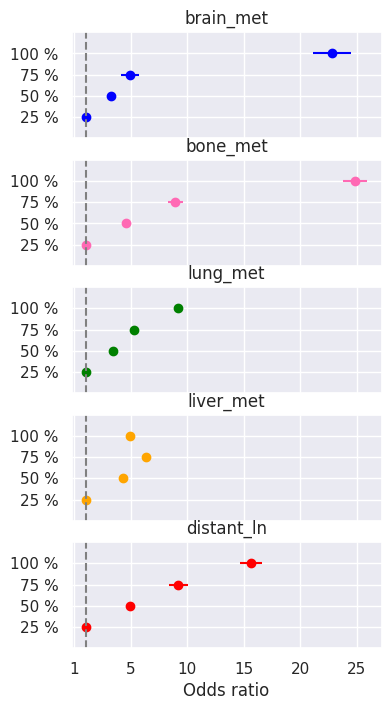

In [8]:
sns.set_theme()

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(4, 8), sharex=True)

ax0 = axes[0]
ax1 = axes[1]
ax2 = axes[2]
ax3 = axes[3]
ax4 = axes[4]

categories = ['brain_met', 'bone_met', 'lung_met', 'liver_met', 'distant_ln']
target_axes = [ax0, ax1, ax2, ax3, ax4]
colors = ['blue', 'hotpink', 'green', 'orange', 'red']
for the_cat, the_axes, the_color in zip(categories, axes, colors):
    the_df = maintable[maintable['response']==the_cat]
    the_axes.set_ylim(0, 5)
    the_axes.set_yticks([1, 2, 3, 4])
    the_axes.set_yticklabels(['25 %', '50 %', '75 %', '100 %'])
    the_axes.set_xticks([])
    i = 1
    the_axes.axvline(1, c='grey', ls='--')
    for _, row in the_df.iterrows():
        the_axes.hlines(y=i, xmin=row['OR_CI_LOW'], xmax=row['OR_CI_HIGH'], colors=the_color)
        the_axes.scatter(row["OR_STAT"], i, marker='o', c=the_color)
        i += 1
        # the_axes.text(y=i, x=row['OR_STAT'], s=row[FEATURE])
        
    the_axes.set_title(the_cat)
ax4.set_xticks([0, 5, 10, 15, 20, 25])
ax4.set_xticklabels(['1', '5', '10', '15', '20', '25'])
ax4.set_xlabel('Odds ratio')
plt.show()

In [6]:

def calc_direct_odds_ratio(pred_field: str, class1: str, class2: str, res_field: str, df) -> Tuple[float, float, float]:
    yn_df = df.groupby(by=[pred_field, res_field]).size().unstack(fill_value=0)
    counts = yn_df.reset_index()
    if 'YES' not in counts.columns:
        counts['YES'] = 0
    if 'NO' not in counts.columns:
        counts['NO'] = 0
    counts = counts.set_index(pred_field, drop=True)
    print(counts)

    counts = counts[counts[pred_field].isin([class1, class2])]
    print(counts)

    res = odds_ratio(counts, kind='sample')
    ci = res.confidence_interval(confidence_level=0.95)
    print(f'OR: {res.statistic}, CI_LOW: {ci.low}, CI_HIGH: {ci.high}')
    return res.statistic, ci.low, ci.high

In [10]:
df.head()

,patient_id,patient_death_year,diagnosis_year,followup_year,diagnosis_agebin,cancer_type,cancer_group,primary_type,primary_group,t_stage_ajcc,n_stage_ajcc,g_stage_ajcc,t_stage_src,n_stage_src,g_stage_src,grade,grade_src,regional_nodes,regional_nodes_examined,regional_nodes_positive,behavior,num_malignant_tumors,num_benign_tumors,psa,breast_subtype,hist_type,hist_cateogry,brain_met,bone_met,lung_met,liver_met,distant_ln,hist_type_descr,TSTAGE_STD,NSTAGE_STD,GSTAGE_STD,GRADE_STD,regional_nodes_prop,regnodes_exam_bin,regnodes_pos_bin,regnodes_prop_bin
1,137,"2,017.00",2012,2017,85-89 years,Myeloma,Leukemia,Myeloma,Leukemia,NaN,NaN,NaN,NaN,NaN,NaN,T_CELL,NaN,NaN,NaN,NaN,MALIGNANT,2,0,NaN,NaN,9732,plasma cell tumors,NO,NO,NO,NO,NO,Plasma cell myeloma,NaN,NaN,NaN,T_CELL,NaN,NaN,NaN,NaN
4,139,"2,011.00",2010,2011,70-74 years,Breast,Breast,Breast,Breast,T3,N0,IIB,NaN,NaN,NaN,G3,NaN,NEG,3.00,0.00,MALIGNANT,3,0,NaN,HR-/HER2-,8500,ductal and lobular neoplasms,NO,NO,NO,NO,NO,Infiltrating duct carcinoma [+ others],T3,N0,II,G3,0.00,"(0, 10]","(0, 10]","(0.00, 0.25]"
5,142,NaN,2018,2020,70-74 years,Breast,Breast,Breast,Breast,T2,N0,IIA,NaN,NaN,NaN,G3,P,NEG,3.00,0.00,MALIGNANT,2,0,NaN,HR-/HER2-,8500,ductal and lobular neoplasms,NO,NO,NO,NO,NO,Infiltrating duct carcinoma [+ others],T2,N0,II,G3,0.00,"(0, 10]","(0, 10]","(0.00, 0.25]"
6,194,NaN,2016,2020,55-59 years,Ovary,Ovary,Ovary,Ovary,T1c,N0,IC,P,P,NaN,G2,NaN,NEG,10.00,0.00,MALIGNANT,2,0,NaN,NaN,8441,"cystic, mucinous and serous neoplasms",NO,NO,NO,NO,NO,Serous carcinoma [+ others],T1,N0,I,G2,0.00,"(0, 10]","(0, 10]","(0.00, 0.25]"
7,220,NaN,2011,2020,70-74 years,Prostate,Prostate,Prostate,Prostate,T1c,N0,II,NaN,NaN,NaN,G2,NaN,NaN,0.00,NaN,MALIGNANT,2,0,6.60,NaN,8140,adenomas and adenocarcinomas,NO,NO,NO,NO,NO,Adenoma [+ others],T1,N0,II,G2,NaN,"(0, 10]",NaN,NaN


In [15]:
# - No loco   -> Loco (only)
# - No loco   -> Dist (only)
# - No loco   -> Loco (any) 
# - No loco   -> Dist (any)
# - No loco   -> Loco & Dist
# - Loco -> Dist (only) 
# - Loco -> Dist (any)
# - Loco -> Loco & Dist

# no NA values allowed
# yes NA values allowed

both_df = df[(df['distant_ln'] == 'YES') & (df['regional_nodes_positive'] > 0)]

loco_df = df[df['regional_nodes_positive'] > 0]
loco_only_df = loco_df[loco_df['distant_ln'] == 'NO']
dist_df = df[df['distant_ln'] == 'YES']
# dist_only_df = dist_df[(dist_df['regional_nodes_positive'] == 0) | (dist_df['regional_nodes_positive'].isna())]
dist_only_df = dist_df[dist_df['regional_nodes_positive'] == 0]
neither_df = df[df['distant_ln'] == 'NO']
neither_df = neither_df[(neither_df['regional_nodes_positive'] == 0) | (neither_df['regional_nodes_positive'].isna())]

loco_df['ln_status'] = 'loco'
loco_only_df['ln_status'] = 'loco_only'
dist_df['ln_status'] = 'dist'
dist_only_df['ln_status'] = 'dist_only'
both_df['ln_status'] = 'both'
neither_df['ln_status'] = 'neither'
temp = pd.concat([loco_df, loco_only_df, dist_df, dist_only_df, both_df, neither_df], ignore_index=True)

print(loco_only_df.shape)
print(loco_only_df[['regional_nodes_positive', 'distant_ln']].head())
print(loco_df.shape)
print(loco_df[['regional_nodes_positive', 'distant_ln']].head())
print(dist_only_df.shape)
print(dist_only_df[['regional_nodes_positive', 'distant_ln']].head())
print(dist_df.shape)
print(dist_df[['regional_nodes_positive', 'distant_ln']].head())
print(both_df.shape)
print(both_df[['regional_nodes_positive', 'distant_ln']].head())
print(neither_df.shape)
print(neither_df[['regional_nodes_positive', 'distant_ln']].head())


(439105, 42)
    regional_nodes_positive distant_ln
10                     1.00         NO
28                     9.00         NO
41                    12.00         NO
44                     3.00         NO
45                     1.00         NO
(443854, 42)
    regional_nodes_positive distant_ln
10                     1.00         NO
28                     9.00         NO
41                    12.00         NO
44                     3.00         NO
45                     1.00         NO
(1491, 42)
       regional_nodes_positive distant_ln
4272                      0.00        YES
5136                      0.00        YES
5343                      0.00        YES
6429                      0.00        YES
20807                     0.00        YES
(62825, 42)
     regional_nodes_positive distant_ln
263                      NaN        YES
393                      NaN        YES
516                      NaN        YES
568                      NaN        YES
802                      NaN   

In [18]:
from util_funcs import calculate_met_stats

stats = calculate_met_stats(
    feature='ln_status',
    response='brain_met',
    df=temp,
    cohort_no=3950523,
    cohort_yes=66108,
)


,NO,YES,records,prevalence (%),OR_STAT,OR_CI_LOW,OR_CI_HIGH
ln_status,,,,,,,
both,4529,220,4749,4.63,2.90,2.53,3.32
dist,56349,6476,62825,10.31,6.87,6.69,7.05
dist_only,1430,61,1491,4.09,2.55,1.97,3.29
loco,441254,2600,443854,0.59,0.35,0.34,0.37
loco_only,436725,2380,439105,0.54,0.33,0.31,0.34
neither,3950523,66108,4016631,1.65,1.00,0.99,1.01


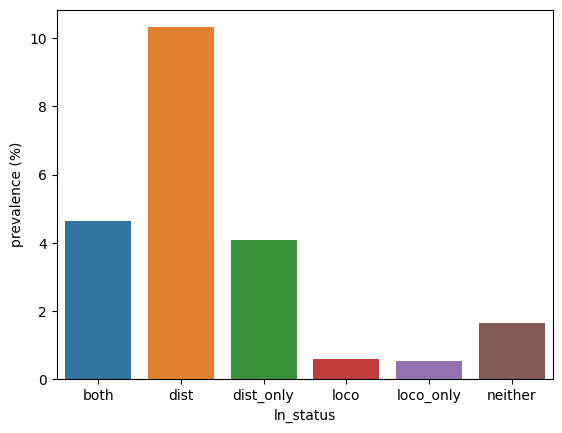

In [20]:
# stats = stats.reset_index()
order = ['neither', 'loco', 'loco_only', 'dist', 'dist_only', 'both']
# stats['ln_status'] = pd.Categorical(stats.ln_status, ordered=True, categories=order)
# stats = stats.sort_values('ln_status')
sns.barplot(data=stats, x='ln_status', y='prevalence (%)', hue='ln_status')
stats

In [ ]:

odds_table = pd.DataFrame(columns=['stat', 'ci_low', 'ci_high'])

for res in ['brain_met', 'bone_met', 'lung_met', 'liver_met']:
    stat, ci_low, ci_high = calc_direct_odds_ratio(
        pred_field='ln_status',
        res_field=res,
        class1='',
        class2='',
        df=df
    )
    